In [1]:
#Imports
import os
import collections
import operator
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from copy import deepcopy
import shutil
import seaborn as sn
import scipy.signal as sg

In [2]:
def print_perc_per_figure(path, hist_acc, figures):
    """Method that stored the accuracy per figure (percentages).

    Args:
        path: dataset used
        hist_acc: matrix containing, for every figure, the accuracy of every figure
        figures: name of the figures
        
    Returns:
       ---

    """
    f = 0
    for h_acc in hist_acc:
        if not np.isnan(h_acc).any():
            file_result = open('results/percentages/' + figures[f] + '_'+ path + '_percentages.txt','w')
            t = 0
            for o_acc in h_acc:
                file_result.write(str(o_acc[len(o_acc)-1]) + ',' + figures[t] + '\n')
                t += 1

            file_result.close()
        f += 1    

In [3]:
def laplace_smoothing(dictionaries, filename):
    """Method that adds unseen states with 0 observations to the dictionaries and then
    applies laplace smoothing with a pseudocount of 1 to compute the probability of finding
    every state in each figure.

    Args:
        dictionaries: array of dictionaries where each dictionary contains the number of
                      observation per state.
        filename: name of the file that has to be classified.
        
    Returns:
        array of dictionaries where each dictionary contains the probability of finding
        every state in each figure.

    """
    dict_copy = deepcopy(dictionaries)
    
    #Unseen states are added with 0 observations
    file = open(filename,'r')
    for line in file:
        line = line.rstrip()
        if line:
            state = line
            for d in dict_copy:
                if state not in d:
                    d[state] = 0
    
    file.close()
    
    #Probabilities are computed applying Laplace Smoothing
    for d in dict_copy:
        N = len(d) #number of different states in the dictionary
        V = sum(d.values()) #total number of observations
        for k,v in d.items():
            d[k] = (v+1)/(N + V)
    
    return dict_copy
    

In [4]:
def bayes(dictionaries, lines, figures):
    """We apply bayes to predict the most probable figure for the given fragment
    Args:
        dictionaries: array of dictionaries where each dictionary contains the probability of finding
        every state in each figure.
        lines: fragment to classify
        figures: figures to compute accuracy
        
    Returns:
        label of the predicted figure and a logg containing the predicted probability for every figure
        in every state
        log: probabilities at every fragment size

    """
    
    priors = np.log10(np.ones((len(dictionaries),))/len(dictionaries))
    probabilities = np.zeros((len(dictionaries),), dtype=np.float)
    
    linenum = 0
    log = []
    labels = []
    for line in lines:
        line = line.rstrip()
        if line:
            state = line
            
            for j in range(0, len(dictionaries)):
                probabilities[j] = math.log10(dictionaries[j][state]) + priors[j]
            
            log.append(probabilities.copy())
            labels.append(figures[list(probabilities).index(max(probabilities))])
            #We store the accumulated probability
            j = 0
            for p in probabilities:
                priors[j] = p
                j += 1
        
    return figures[list(probabilities).index(max(probabilities))], log, labels

In [19]:
def get_accuracy(states_dict, max_iter, path, generate_tags_over_time, figures, directory):
    """
    Method that computes the accuracy for a given fragment size
    Args:
        states_dict: array of dictionaries where each dictionary contains the probability of finding
        every state in each figure.
        max_iter: fragment size
        path: directory to use
        generate_tags_over_time: flag that indicates if the predicted figure at every instant
        must be stored
        figures: figures to compute accuracy
    
    Returns:
        acc[i][j]:
            i = class y
            j = number of fragments predicted as figure y

    """
    
    acc = np.zeros((len(figures),len(figures)))
            
    for filename in os.listdir(path):
        
        if filename == '.DS_Store':
            continue
            
        figure = filename.split('_')[0]
        dictionaries = laplace_smoothing(states_dict, path + '/' + filename)
        
        file = open(path + '/' + filename,'r')
        lines = file.readlines()
        
        if max_iter > len(lines):
            max_iter = len(lines)
        
        if generate_tags_over_time:
            file_classification = open('classification_' + directory + '/' + figure + '.txt','w')
        
        for i in range(0, int(len(lines)/max_iter)):
            result, log, labels = bayes(dictionaries, lines[max_iter * i : max_iter * i + max_iter],figures)
            acc[figures.index(figure)][figures.index(result)] += 1
            
            if generate_tags_over_time == True:
                print('classification_' + directory + '/' + figure + '.txt')
                if (os.path.isdir('classification_' + directory) == False):
                    try:
                        #shutil.rmtree('classification_' + directory)
                        os.mkdir('classification_' + directory)
                    except:
                        print("no puc crear el f*cking directori: classification_" + directory)
                        
                for label in labels:
                    file_classification.write(label + '\n')
    
    
    return acc
    

In [14]:
def plot_accuracy(hist_acc, x_ticks, figures, path, 
                  fig_dir='./results/figures/', save_results=False):
    
    fig_name = path.split('/')
    fig_name = fig_name[len(fig_name)-2]+'_'+fig_name[len(fig_name)-1]
    
    #Just one fragment classification test
    if len(x_ticks) == 1:
        acc= np.zeros((len(hist_acc[0]), len(hist_acc[0])))
        
        for i in range(0, len(hist_acc)):
            for j in range(0, len(hist_acc)):
                acc[i][j] = hist_acc[i][j][0]
        
        plt.title('Confussion matrix for %s' % (path))
        sn.heatmap(acc,cmap='Blues',xticklabels=figures, yticklabels=figures)
        
        if save_results:
            plt.savefig('%s.png' % (fig_dir + fig_name),dpi=600)
            
        plt.show()
        
    else:
        f = 0
        
        if save_results:
            pdf = open('%s.pdf' % (fig_dir + fig_name), 'w')
        
        for h_acc in hist_acc:
            for obj_acc in h_acc:
                plt.plot(x_ticks,obj_acc)

            plt.ylabel('Accuracy (%)')
            plt.xlabel('Time (s)')
            plt.legend(figures)
            plt.title('Accuracy ' + figures[f])

            if save_results:
                plt.savefig('%s.png' % (fig_dir + fig_name),dpi=600)

            plt.show()
            f += 1
            
        if save_results:
            pdf.close()

In [15]:
def classify(directories, min_fragment_size, max_fragment_size, 
             generate_tags_over_time=False, print_percentages=False, 
             fig_dir='./results/figures/', save_results=False):
    """
    Naive Bayes Classifier
    Args:
        directories: datasets' folders
        min_fragment_size: smallest fragment size
        max_fragment_size: biggest fragment size
        generate_tags_over_time: flag that indicates if the predicted figure at every instant
        print_percentage: flag that indicated if the final accuracy per figure must be stored
        must be stored
    
    Returns:
        --

    """
    
    for k in range (0, len(directories)):
        path = directories[k]
        hist_acc = []
        figures = []
        states_dict = []
        lines = []
        
        for filename in os.listdir(path):
            if filename == '.DS_Store':
                continue
            
            figure = filename.split('_')[0]
            if figure not in figures:
                figures.append(figure)
                states_dict.append(dict())

            #Training, compute the number of observations per state
            file = open(path + "/" + filename,'r')
            lines = file.readlines()
            print("Training %s/%s, with %d states.\r" % (path, filename, len(lines)))
            
            for line in lines:
                line = line.rstrip()
                if line:
                    state = line
                    if state in states_dict[figures.index(figure)]:
                        states_dict[figures.index(figure)][state] += 1
                    else:
                        states_dict[figures.index(figure)][state] = 1
                        
        print("Training of %s ended.\n" % (path))

        for i in range(0, len(figures)):
            acc_fig = []
            for j in range(0, len(figures)):
                acc_fig.append([])
            hist_acc.append(acc_fig)


        #Add structure for unseen figures
        for filename in os.listdir(path +'_test'):
            if filename == '.DS_Store':
                continue

            figure = filename.split('_')[0]
            if figure not in figures:
                figures.append(figure)
                for i in range(0, len(hist_acc)):
                    hist_acc[i].append([])

                acc_fig = []
                for j in range(0, len(figures)):
                    acc_fig.append([])
                hist_acc.append(acc_fig)

        #Compute accuracy for every fragment size
        x_ticks = []
        
        for it in range(min_fragment_size, max_fragment_size+1):
            acc = get_accuracy(states_dict, it, path+'_test/', generate_tags_over_time, figures, directories[k])
            print("Testing %s with %d states." % (path+'_test/', it))
            
            x_ticks.append(it*0.025)

            for j in range(0,len(acc)):
                totalfiles = 0

                #Total number of classified fragments
                for acc_i in range(0,len(acc[j])):
                    totalfiles += acc[j][acc_i]

                #Accuracy
                for acc_i in range(0,len(acc[j])):
                    hist_acc[j][acc_i].append(acc[j][acc_i]/totalfiles*100)
                    
        print("Testing of %s ended." % (path))
        
        #Plot accuracy
        plot_accuracy(hist_acc, x_ticks, figures, path, fig_dir, save_results)
            
        
        if print_percentages == True:
            print_perc_per_figure(path.replace("/", "_"), hist_acc,figures)

## Executa el classificador compilat

The dataset variable must contain a string with the path were is located the dataset:
* The directory that contains the dataset must have for each experiment a _training_\__directory_ with any name and a _test_\__directory_ with the same name as the _training_\__directory_ + '_\_test_'.
* The name of the files located in the _test_\__directory_ and _training_\__directory_ must start with the name of the figure + '\_'.

The variables ```min_fragment_size``` and ```max_fragment_size``` indicates the different test fragments sizes and allows you to test the classifier taking different amounts of test samples. 
* If both are set at the same size, only one test will be computed.
* If the fragment is larger than the test file + 1, only one classification per experiment will be computed.

If the variable ```generate_tags_over_time``` is set to True, a file with the classification for each state of each test file will be created.

Dataset:  4figures
Directories:  ['./datasets/125Hz/4figures']
Training ./datasets/125Hz/4figures/lat20_states.txt, with 1124983 states.
Training ./datasets/125Hz/4figures/lat15_states.txt, with 1124972 states.
Training ./datasets/125Hz/4figures/lat05_states.txt, with 1124979 states.
Training ./datasets/125Hz/4figures/lat00_states.txt, with 1124979 states.
Training of ./datasets/125Hz/4figures ended.

Testing ./datasets/125Hz/4figures_test/ with 1000 states.
Testing of ./datasets/125Hz/4figures ended.


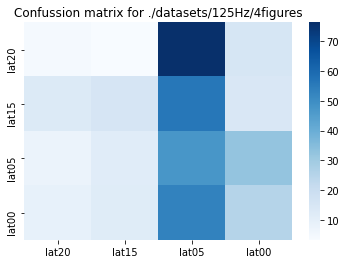

In [17]:
dataset = './datasets/40Hz'

min_fragment_size = 1000
max_fragment_size = 1000
generate_tags_over_time = False
print_percentages = True
save_results = True

#Clean results
res_dir = './results'
class_dir = './results/classification'
perc_dir = './results/percentages'
fig_dir = './results/figures/'

if not os.path.exists(res_dir):
    os.mkdir(res_dir)
    os.mkdir(class_dir)
    os.mkdir(perc_dir)
    os.mkdir(fig_dir)

#For each training directory in dataset
directories = []
for baseline in os.listdir(dataset):
    if not 'test' in baseline and not '.DS_Store' in baseline:
        print('Dataset: ', baseline)
        directories.append(dataset + '/' + baseline)
    
if (min_fragment_size != max_fragment_size) and generate_tags_over_time == True:
    print('Error! Tags can only be computed for a specific fragment size (min = max).')
    print('Remember that if (max_fragment_size < 12000/2 + 1) multiple classification batches will be generated')
else:
    print('Directories: ', directories)
    classify(directories, min_fragment_size, max_fragment_size, 
             generate_tags_over_time, print_percentages, 
             fig_dir, save_results)

## Classifier that generates pdf with the output

In [93]:
from matplotlib.backends.backend_pdf import PdfPages

def classify(directories, min_fragment_size, max_fragment_size, generate_tags_over_time, print_percentages):
    """
    Naive Bayes Classifier
    Args:
        directories: datasets' folders
        min_fragment_size: smallest fragment size
        max_fragment_size: biggest fragment size
        generate_tags_over_time: flag that indicates if the predicted figure at every instant
        print_percentage: flag that indicated if the final accuracy per figure must be stored
        must be stored
    
    Returns:
        --

    """
    with PdfPages('Baseline_3figs.pdf') as pdf:
        for k in range (0, len(directories)):

            path = directories[k]
            hist_acc = []
            figures = []
            states_dict = []
            lines = []

            for filename in os.listdir(path):
                if filename == '.DS_Store':
                    continue

                figure = filename.split('_')[0]
                if figure not in figures:
                    figures.append(figure)
                    states_dict.append(dict())

                #Training, compute the number of observations per state
                file = open(path + "/" + filename,'r')
                for line in file.readlines():
                    line = line.rstrip()
                    if line:
                        state = line
                        if state in states_dict[figures.index(figure)]:
                            states_dict[figures.index(figure)][state] += 1
                        else:
                            states_dict[figures.index(figure)][state] = 1

            for i in range(0, len(figures)):
                acc_fig = []
                for j in range(0, len(figures)):
                    acc_fig.append([])
                hist_acc.append(acc_fig)


            #Add structure for unseen figures
            for filename in os.listdir(path +'_test'):
                if filename == '.DS_Store':
                    continue

                figure = filename.split('_')[0]
                if figure not in figures:
                    figures.append(figure)
                    for i in range(0, len(hist_acc)):
                        hist_acc[i].append([])

                    acc_fig = []
                    for j in range(0, len(figures)):
                        acc_fig.append([])
                    hist_acc.append(acc_fig)

            #Compute accuracy for every fragment size
            x_ticks = []

            for it in range(min_fragment_size, max_fragment_size+1):
                acc = get_accuracy(states_dict, it,path, generate_tags_over_time, figures)
                x_ticks.append(it*0.025)

                for j in range(0,len(acc)):
                    totalfiles = 0

                    #Total number of classified fragments
                    for k in range(0,len(acc[j])):
                        totalfiles += acc[j][k]

                    #Accuracy
                    for k in range(0,len(acc[j])):
                        hist_acc[j][k].append(acc[j][k]/totalfiles*100)

            #Plot accuracy
            f = 0
            n_fig = 0

            for h_acc in hist_acc:
                for obj_acc in h_acc:
                    plt.plot(x_ticks,obj_acc)

                plt.ylabel('Accuracy (%)')
                plt.xlabel('Time (s)')
                plt.legend(figures)
                plt.title('Accuracy ' + figures[f] + " | Baseline: " + figures[0] + ", " + figures[1] + ", " + figures[2])
                #plt.savefig('results/acc_'+ path.replace("/", "_") + '_' + figures[f] + '.png',dpi=600)


                f += 1
                n_fig += 1
                if n_fig > 3:
                    print(n_fig)
                    pdf.savefig()
                
                plt.show()


            if print_percentages == True:
                print_perc_per_figure(path.replace("/", "_"), hist_acc,figures)

## Classifier that generates the *_Number of times a figure is classified as another one_* MATRIX

In [ ]:
def classify(directories, min_fragment_size, max_fragment_size, generate_tags_over_time, print_percentages):
    """
    Naive Bayes Classifier
    Args:
        directories: datasets' folders
        min_fragment_size: smallest fragment size
        max_fragment_size: biggest fragment size
        generate_tags_over_time: flag that indicates if the predicted figure at every instant
        print_percentage: flag that indicated if the final accuracy per figure must be stored
        must be stored
    
    Returns:
        --

    """
    for k in range (0, 1):#len(directories)):

        path = directories[k]
        hist_acc = []
        figures = []
        states_dict = []
        lines = []
        
        for filename in os.listdir(path):
            if filename == '.DS_Store':
                continue

            figure = filename.split('_')[0]
            if figure not in figures:
                figures.append(figure)
                states_dict.append(dict())

            #Training, compute the number of observations per state
            file = open(path + "/" + filename,'r')
            for line in file.readlines():
                line = line.rstrip()
                if line:
                    state = line
                    if state in states_dict[figures.index(figure)]:
                        states_dict[figures.index(figure)][state] += 1
                    else:
                        states_dict[figures.index(figure)][state] = 1

        for i in range(0, len(figures)):
            acc_fig = []
            for j in range(0, len(figures)):
                acc_fig.append([])
            hist_acc.append(acc_fig)


        #Add structure for unseen figures
        for filename in os.listdir(path +'_test'):
            if filename == '.DS_Store':
                continue

            figure = filename.split('_')[0]
            if figure not in figures:
                figures.append(figure)
                for i in range(0, len(hist_acc)):
                    hist_acc[i].append([])

                acc_fig = []
                for j in range(0, len(figures)):
                    acc_fig.append([])
                hist_acc.append(acc_fig)

        #Compute accuracy for every fragment size
        x_ticks = []
        
        for it in range(min_fragment_size, max_fragment_size+1):
            print(it)
            acc = get_accuracy(states_dict, it,path, generate_tags_over_time, figures)
            
            for i in range (0, len(acc)):
                suma = sum(acc[i])
                for j in range (0, len(acc[i])):
                    acc[i][j] /= suma
            
            print(acc)
            plt.title('Accuracy per un fragment de ' + str(it/40) + 'segons')
            sn.heatmap(acc,cmap='Blues',xticklabels=figures, yticklabels=figures)
            plt.savefig(directories[0].split('/')[0] + "/images/"+ path.split('/')[1]  +".png")
            plt.show()
            
            

## Gràfiques filtrades

Si no vols generar les gràfiques filtrades, no compilis les següents dos cel·les.

In [42]:
#Filter parameters
#order
N = 6
#sampling frequency
fs = 40
#cutoff frequency
fc = 0.5
#Wn = fc/(fs/2)
Wn = fc/(fs/2)

b, a = sg.butter(N, Wn, 'low')

In [54]:
def classify(directories, min_fragment_size, max_fragment_size, generate_tags_over_time, print_percentages):
    """
    Naive Bayes Classifier
    Args:
        directories: datasets' folders
        min_fragment_size: smallest fragment size
        max_fragment_size: biggest fragment size
        generate_tags_over_time: flag that indicates if the predicted figure at every instant
        print_percentage: flag that indicated if the final accuracy per figure must be stored
        must be stored
    
    Returns:
        --

    """
    for k in range (0, len(directories)):

        path = directories[k]
        hist_acc = []
        figures = []
        states_dict = []
        lines = []

        for filename in os.listdir(path):

            if filename == '.DS_Store':
                continue

            figure = filename.split('_')[0]
            if figure not in figures:
                figures.append(figure)
                states_dict.append(dict())

            #Training, compute the number of observations per state
            file = open(path + "/" + filename,'r')
            for line in file.readlines():
                line = line.rstrip()
                if line:
                    state = line
                    if state in states_dict[figures.index(figure)]:
                        states_dict[figures.index(figure)][state] += 1
                    else:
                        states_dict[figures.index(figure)][state] = 1

        for i in range(0, len(figures)):
            acc_fig = []
            for j in range(0, len(figures)):
                acc_fig.append([])
            hist_acc.append(acc_fig)


        #Add structure for unseen figures
        for filename in os.listdir(path +'_test'):
            if filename == '.DS_Store':
                continue

            figure = filename.split('_')[0]
            if figure not in figures:
                figures.append(figure)
                for i in range(0, len(hist_acc)):
                    hist_acc[i].append([])

                acc_fig = []
                for j in range(0, len(figures)):
                    acc_fig.append([])
                hist_acc.append(acc_fig)


        #Compute accuracy for every fragment size
        x_ticks = []
        
        for it in range(min_fragment_size, max_fragment_size+1):
            print(it)
            print('k: ', k)
            acc = get_accuracy(states_dict, it,path, generate_tags_over_time, figures, directories[k])
            x_ticks.append(it*0.025)

            for j in range(0,len(acc)):
                totalfiles = 0

                #Total number of classified fragments
                for acc_i in range(0,len(acc[j])):
                    totalfiles += acc[j][acc_i]

                #Accuracy
                for acc_i in range(0,len(acc[j])):
                    hist_acc[j][acc_i].append(acc[j][acc_i]/totalfiles*100)

        #Plot accuracy
        f = 0
        accu = []

        for h_acc in hist_acc:
            t = 0
            plt.figure(figsize=(10,7))
            plt.rcParams.update({'font.size': 32})
            
            for obj_acc in h_acc:
                filtered = sg.filtfilt(b, a, obj_acc)
                plt.plot(x_ticks, filtered, linewidth=5)
                if t == f:
                    accu.append(obj_acc)
                t += 1

            plt.ylabel('Accuracy (%)')
            plt.xlabel('Time (s)')
            plt.legend(figures)
            plt.title('Accuracy ' + figures[f])
            plt.savefig(figures[f] + '.png', bbox_inches='tight', dpi=600)
            plt.savefig(figures[f] + '.svg', bbox_inches='tight', dpi=600)
            plt.show()
            f += 1
            

## Executa el classificador compilat

1
k:  0
2
k:  0
3
k:  0
4
k:  0
5
k:  0
6
k:  0
7
k:  0
8
k:  0
9
k:  0
10
k:  0
11
k:  0
12
k:  0
13
k:  0
14
k:  0
15
k:  0
16
k:  0
17
k:  0
18
k:  0
19
k:  0
20
k:  0
21
k:  0
22
k:  0
23
k:  0
24
k:  0
25
k:  0
26
k:  0
27
k:  0
28
k:  0
29
k:  0
30
k:  0
31
k:  0
32
k:  0
33
k:  0
34
k:  0
35
k:  0
36
k:  0
37
k:  0
38
k:  0
39
k:  0
40
k:  0
41
k:  0
42
k:  0
43
k:  0
44
k:  0
45
k:  0
46
k:  0
47
k:  0
48
k:  0
49
k:  0
50
k:  0
51
k:  0
52
k:  0
53
k:  0
54
k:  0
55
k:  0
56
k:  0
57
k:  0
58
k:  0
59
k:  0
60
k:  0
61
k:  0
62
k:  0
63
k:  0
64
k:  0
65
k:  0
66
k:  0
67
k:  0
68
k:  0
69
k:  0
70
k:  0
71
k:  0
72
k:  0
73
k:  0
74
k:  0
75
k:  0
76
k:  0
77
k:  0
78
k:  0
79
k:  0
80
k:  0
81
k:  0
82
k:  0
83
k:  0
84
k:  0
85
k:  0
86
k:  0
87
k:  0
88
k:  0
89
k:  0
90
k:  0
91
k:  0
92
k:  0
93
k:  0
94
k:  0
95
k:  0
96
k:  0
97
k:  0
98
k:  0
99
k:  0
100
k:  0
101
k:  0
102
k:  0
103
k:  0
104
k:  0
105
k:  0
106
k:  0
107
k:  0
108
k:  0
109
k:  0
110
k:  0
111
k:  

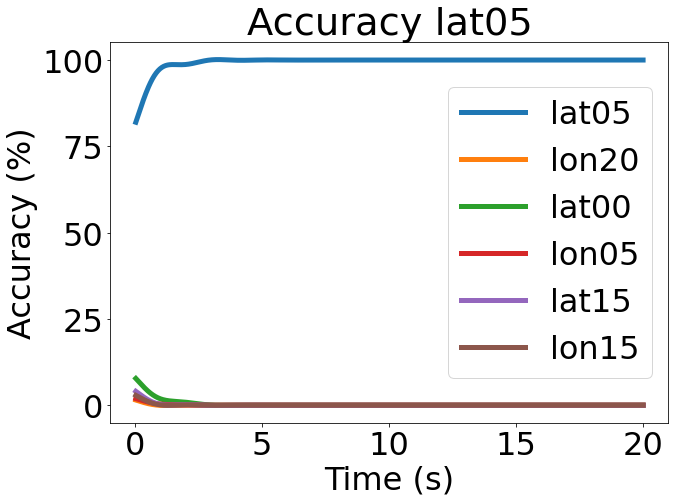

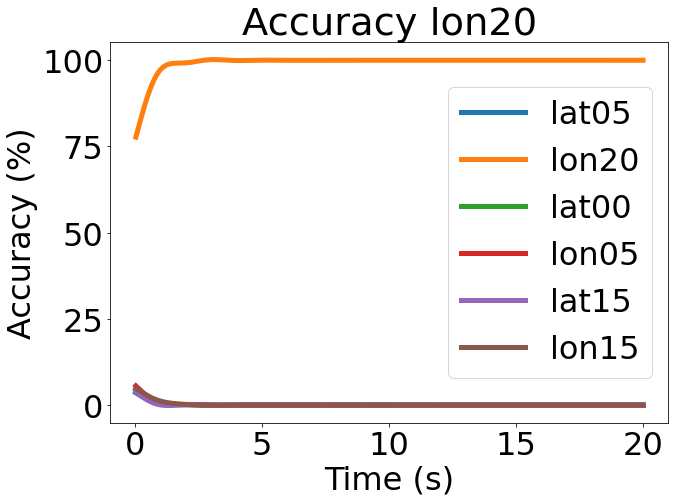

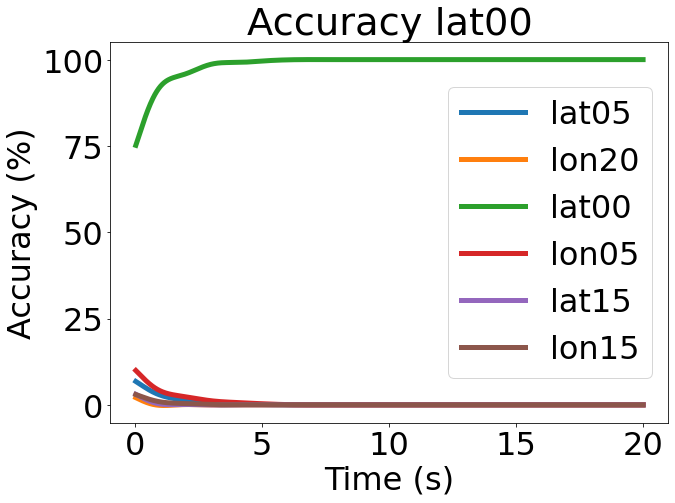

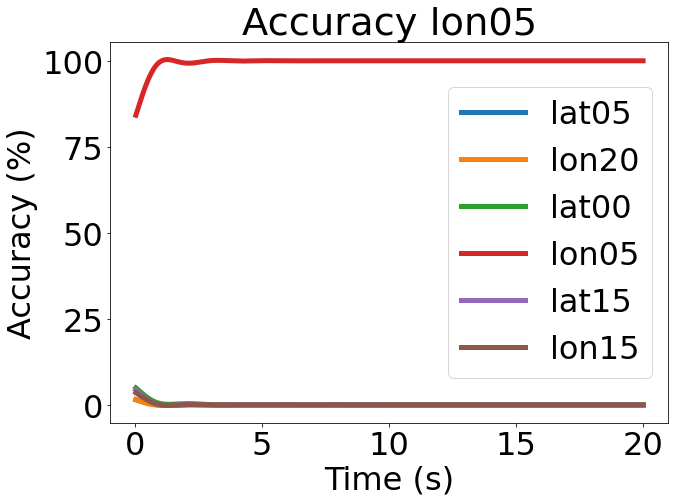

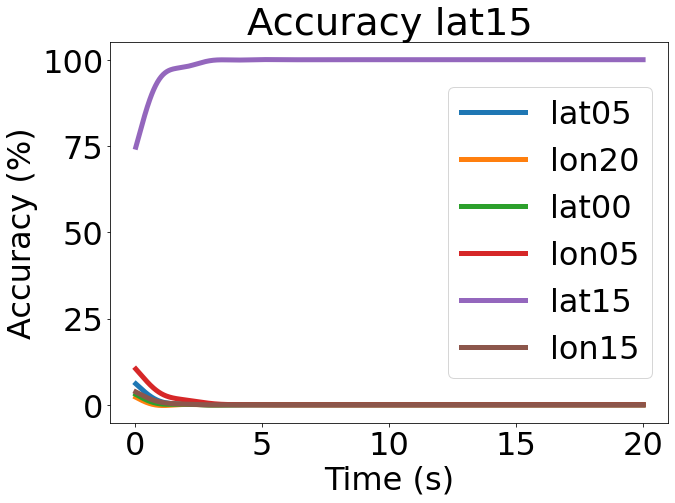

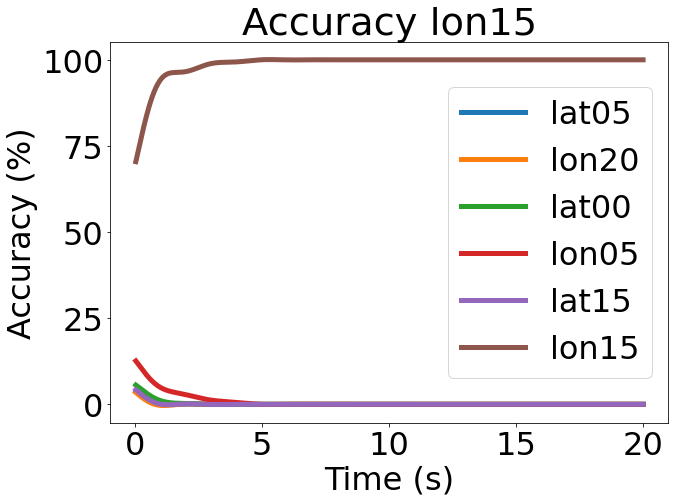

In [56]:
#directories = ['dataset_clean']
'''directories = ["dataset_similarities/dataset_no_lat00", \
                "dataset_similarities/dataset_no_lat05", \
                "dataset_similarities/dataset_no_lat15", \
                "dataset_similarities/dataset_no_lon05", \
                "dataset_similarities/dataset_no_lon15",\
                "dataset_similarities/dataset_no_lon20"]'''
'''directories = ['dataset_molyneux/dataset_clean']'''
'''directories = ["dataset_15/1", "dataset_15/2", "dataset_15/3", \
               "dataset_15/4", "dataset_15/5", "dataset_15/6", \
               "dataset_15/7", "dataset_15/8", "dataset_15/9", \
               "dataset_15/10", "dataset_15/11", "dataset_15/12", \
               "dataset_15/13", "dataset_15/14", "dataset_15/15"]'''


'''directories = ["dataset_step3/1", "dataset_step3/2", "dataset_step3/3", \
               "dataset_step3/4", "dataset_step3/5", "dataset_step3/6", \
               "dataset_step3/7", "dataset_step3/8", "dataset_step3/9", \
               "dataset_step3/10", "dataset_step3/11", "dataset_step3/12", \
               "dataset_step3/13", "dataset_step3/14", "dataset_step3/15"]'''
'''
directories = ["dataset_lowvi - 4 class/1", \
                "dataset_lowvi - 4 class/2", \
                "dataset_lowvi - 4 class/3", \
                "dataset_lowvi - 4 class/4"]'''

'''directories = ["dataset_baseline_2figures/1", "dataset_baseline_2figures/2", "dataset_baseline_2figures/3", \
               "dataset_baseline_2figures/4", "dataset_baseline_2figures/5", "dataset_baseline_2figures/6", \
               "dataset_baseline_2figures/7", "dataset_baseline_2figures/8", "dataset_baseline_2figures/9", \
               "dataset_baseline_2figures/10", "dataset_baseline_2figures/11", "dataset_baseline_2figures/12", \
               "dataset_baseline_2figures/13", "dataset_baseline_2figures/14", "dataset_baseline_2figures/15"]'''

'''directories = ["dataset_baseline_3figures/1", "dataset_baseline_3figures/2", "dataset_baseline_3figures/3", \
               "dataset_baseline_3figures/4", "dataset_baseline_3figures/5", "dataset_baseline_3figures/6", \
               "dataset_baseline_3figures/7", "dataset_baseline_3figures/8", "dataset_baseline_3figures/9", \
               "dataset_baseline_3figures/10", "dataset_baseline_3figures/11", "dataset_baseline_3figures/12", \
               "dataset_baseline_3figures/13", "dataset_baseline_3figures/14", "dataset_baseline_3figures/15"]'''

'''directories = ["dataset_baseline_4figures/1", "dataset_baseline_4figures/2", "dataset_baseline_4figures/3", \
               "dataset_baseline_4figures/4", "dataset_baseline_4figures/5", "dataset_baseline_4figures/6", \
               "dataset_baseline_4figures/7", "dataset_baseline_4figures/8", "dataset_baseline_4figures/9", \
               "dataset_baseline_4figures/10", "dataset_baseline_4figures/11", "dataset_baseline_4figures/12", \
               "dataset_baseline_4figures/13", "dataset_baseline_4figures/14", "dataset_baseline_4figures/15"]'''

#directories = ["dataset_lowvi"]

directories = ["datasets/dataset_clean"]

min_fragment_size = 1
max_fragment_size = 800
generate_tags_over_time = False
print_percentages = True

#Clean results
res_dir = 'results'
class_dir = 'results/classification'
perc_dir = 'results/percentages'
if os.path.exists(res_dir):
    shutil.rmtree(res_dir)
os.mkdir(res_dir)
os.mkdir(class_dir)
os.mkdir(perc_dir)
    
if (min_fragment_size != max_fragment_size) and generate_tags_over_time == True:
    print('Error! Tags can only be computed for a specific fragment size (min = max).')
    print('Remember that if (max_fragment_size < 12000/2 + 1) multiple classification batches will be generated')
else:
    classify(directories, min_fragment_size, max_fragment_size, generate_tags_over_time, print_percentages)

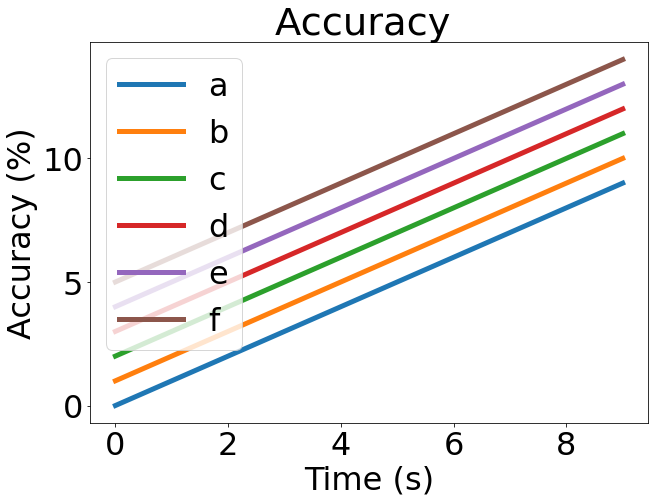

NameError: name 'f' is not defined

In [53]:
for i in range(6):
    t = 0
    plt.figure(figsize=(10,7))
    plt.rcParams.update({'font.size': 32})
    
    for obj_acc in range(6):
        #filtered = sg.filtfilt(b, a, obj_acc)
        plt.plot(list(range(10)),list(range(t, 10+t)), linewidth=5)
        
        t += 1
        
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Time (s)')
    plt.legend(["a", "b", "c", "d", "e", "f"])
    plt.title('Accuracy ' )
    plt.savefig('test.png', bbox_inches='tight', dpi=600)
    plt.show()
    f += 1

In [ ]:
#Number of different states per figure
PATH = 'dataset_clean/'
NUM_FIG = 9
states_per_fig = []
figures = []

for i in range(0,NUM_FIG):
    states_per_fig.append(dict())


for filename in os.listdir(PATH):
    if '.txt' in filename and '4' not in filename:
        file = open(PATH + filename)
        figure = filename.split('_')[0]
        
        if figure not in figures:
            figures.append(figure)
        
        for line in file:
            state = line.rstrip()
            
            if state in states_per_fig[figures.index(figure)]:
                states_per_fig[figures.index(figure)][state] += 1
            else:
                states_per_fig[figures.index(figure)][state] = 1
                
number_of_states = []
for i in range(0,NUM_FIG):
    number_of_states.append(len(states_per_fig[i].keys()))

x = np.arange(NUM_FIG)
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.bar(x, number_of_states)
ax.set_xlabel('Figure')
ax.set_ylabel('Number of different states')
plt.xticks(x, figures)
fig.savefig('results/diff_states.png',dpi=300,bbox_inches='tight')
plt.show()

#Frequency of the different states per figure
for i in range(0, NUM_FIG):
    sorted_dict = collections.OrderedDict(sorted(states_per_fig[i].items(), key=operator.itemgetter(1), reverse = True))
    values = sorted_dict.values()
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    ax.plot(values)
    ax.set_xlabel('State')
    ax.set_ylabel('Number of repetitions per state')
    fig.savefig('results/freq_' + figures[i] + '.png',dpi=300,bbox_inches='tight')
    plt.show()
        